# Report for MRI data

1. [Packages](#packages)
2. [Data](#data)
3. [Load data from GoogleDrive](#google)
4. [Load data](#load)
5. [Data exploration](#exploration)
6. [Data preprocessing](#preproc)
7. [Stat](#stats)
8. [Plots](#draw)
9. [Prepare data for YOLO](#prepare_yolo)
8. [Evaluate](#eval)
8. [Plots of metrics](#plots)
8. [Visualization of results](#visual)


## 1. Packages <a class="anchor" id="packages"></a>

In [1]:
import os
import pandas as pd
import numpy as np

%matplotlib inline
import src.upload_utils as ut

import constants as const
import src.draw_utils as du
import src.upload_yolo_utils as yu
from src.yolo_models import *

In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

## 2. Data <a class="anchor" id="data"></a>

### 2.1 Load data from GoogleDrive and unzip <a class="anchor" id="google"></a>

In [3]:
ut.download_file_from_google_drive(id=const.FILE_ID, 
                                   destination=const.DATA_ZIP)

In [4]:
ut.unzip_data(zip_file=const.DATA_ZIP)

### 2.2. Load data <a class="anchor" id="load"></a>

In [5]:
mri_df_raw = ut.load_data(from_dir=const.PATH_FILES)

[{upload_utils.py:31} INFO - Load from /Users/valeriakaravaeva/Documents/git/_LK/MRI_yolo/data/descr/ 12 files
[{upload_utils.py:36} INFO - Concat list of data frames
[{upload_utils.py:40} INFO - Finish read df = (916, 20)


### 2.3. Data exploration <a class="anchor" id="exploration"></a>

In [6]:
mri_df_raw.head()

ID Исследователь                 Кейс            Файлы  \
0  2872   Denis Shpak  4773 - dcm-dromanov  img_00215.jpg/n   
1  3144   Denis Shpak  4774 - dcm-dromanov  img_00226.jpg/n   
2  5571   Denis Shpak  4791 - dcm-dromanov  img_00200.jpg/n   
3  5572   Denis Shpak  4791 - dcm-dromanov  img_00200.jpg/n   
4  5573   Denis Shpak  4791 - dcm-dromanov  img_00200.jpg/n   

                 Протокол                                                XML  \
0  MRI_NECK_SAG_prot_hern  <annotation>\r\n            <filename>https://...   
1  MRI_NECK_SAG_prot_hern  <annotation>\r\n            <filename>https://...   
2  MRI_NECK_SAG_prot_hern                                                NaN   
3  MRI_NECK_SAG_prot_hern                                                NaN   
4  MRI_NECK_SAG_prot_hern                                                NaN   

   Файлы разметки На срезе визуализируются межпозвоночные диски  \
0             NaN                                           NaN   
1             NaN             Визуализируются (можно размечать)   
2             NaN             Визуализируются (можно размечать)   
3             NaN             Визуализируются (можно размечать)   
4             NaN             Визуализируются (можно размечать)   

   Шейный межпозвоночный диск - здоровый  \
0                                    NaN   
1                                    NaN   
2                                    NaN   
3                                    NaN   
4                                    NaN   

   Шейный межпозвоночный диск - с подозрением на патологию  \
0                                                NaN         
1                                                NaN         
2                                                NaN         
3                                                NaN         
4                                                NaN         

   Шейный межпозвоночный диск - патологический  \
0                                          NaN   
1                                          NaN   
2                                          NaN   
3                                          NaN   
4                                          NaN   

   грудной межпозвоночный диск - здоровый  \
0                                     NaN   
1                                     NaN   
2                                     NaN   
3                                     NaN   
4                                     NaN   

   грудной межпозвоночный диск - с подозрением на паталогию  \
0                                                NaN          
1                                                NaN          
2                                                NaN          
3                                                NaN          
4                                                NaN          

   грудной межпозвоночный диск - патологический  \
0                                           NaN   
1                                           NaN   
2                                           NaN   
3                                           NaN   
4                                           NaN   

   поясничный межпозвоночный диск - здоровый  \
0                                        NaN   
1                                        NaN   
2                                        NaN   
3                                        NaN   
4                                        NaN   

   поясничный межпозвоночный диск - с подозрением на патологию  \
0                                                NaN             
1                                                NaN             
2                                                NaN             
3                                                NaN             
4                                                NaN             

   поясничный межпозвоночный диск - патологический  \
0                                              NaN   
1                                              NaN  

In [7]:
mri_df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 916 entries, 0 to 915
Data columns (total 20 columns):
ID                                                             916 non-null int64
Исследователь                                                  916 non-null object
Кейс                                                           916 non-null object
Файлы                                                          916 non-null object
Протокол                                                       916 non-null object
XML                                                            892 non-null object
Файлы разметки                                                 0 non-null float64
На срезе визуализируются межпозвоночные диски                  896 non-null object
Шейный межпозвоночный диск - здоровый                          0 non-null float64
Шейный межпозвоночный диск - с подозрением на патологию        0 non-null float64
Шейный межпозвоночный диск - патологический                    0 non-

In [8]:
mri_df_raw['На срезе визуализируются межпозвоночные диски'].value_counts()

Не визуализируются (срез не пригоден для разметки)    531
Визуализируются (можно размечать)                     365
Name: На срезе визуализируются межпозвоночные диски, dtype: int64

### 2.3. Data preprocessing <a class="anchor" id="preproc"></a>

#### We have function of "main preprocessing":
* parse xml column
* Filter our data by:
    * **deleted** = 0
    * **imagesize** = 384*384
    * **type_mri** = shejnyi
    * **На срезе визуализируются межпозвоночные диски** = Визуализируются (можно размечать) 
* drop uninformation column:
    * imagesize
    * name
    * verified
    * occluded
    * deleted
    * date
    * parts
* Convert columns of type_disk to English label and integer label


In [10]:
mri_clean, imgs_set = ut.main_preprocessing(df=mri_df_raw, 
                                            columns_out=const.COLUMNS, 
                                            type_disk=const.TYPE_DISK, 
                                            cat_type_disk=const.CAT_TYPE_DISK, 
                                            path_clean_data=const.PATH_CLEAN_DATA, 
                                            is_split=True, 
                                            path_test_data=const.PATH_TEST_DATA)
mri_clean.head()

[{upload_utils.py:189} INFO - Start parse XML column
[{upload_utils.py:80} INFO - Start preprocessing data, shape = (916, 20)
[{upload_utils.py:82} INFO - Clean data (visualize disk)
[{upload_utils.py:85} INFO - Drop NaN columns of XML
[{upload_utils.py:90} INFO - Start parse XML, shape = (356, 20)
[{upload_utils.py:132} INFO - Adding column type_mri
[{upload_utils.py:135} INFO - Stats by type_mri {'shejnyj': 1702, 'grudnoj': 990, 'hernia': 1, 'protrusion': 1}
[{upload_utils.py:136} INFO - Stats by deleted {'0': 2676, '1': 18}
[{upload_utils.py:137} INFO - Stats by imagesize {'384, 384': 2675, '512, 512': 19}
[{upload_utils.py:139} INFO - Filtering data, shape before = (2694, 16)
[{upload_utils.py:144} INFO - Adding column type of disk
[{upload_utils.py:148} INFO - Adding column label (category)
[{upload_utils.py:153} INFO - Filtering data, shape before = (1665, 18)
[{upload_utils.py:156} INFO - Category {'patalogical': 0, 'suspicion': 1, 'healthy': 2}
[{upload_utils.py:157} INFO - Fil

id label           file    type_disk  height  width    x    y  x_center  \
0  3144     2  img_00226.jpg      healthy      12     29  172  107     186.5   
1  3144     2  img_00226.jpg      healthy      12     25  168  132     180.5   
2  3144     2  img_00226.jpg      healthy      12     24  164  156     176.0   
3  3144     0  img_00226.jpg  patalogical      16     25  164  178     176.5   
4  3144     2  img_00226.jpg      healthy      19     27  165  203     178.5   

   y_center  
0     113.0  
1     138.0  
2     162.0  
3     186.0  
4     212.5

### 2.4. Stats by clean data <a class="anchor" id="stats"></a>

In [11]:
mri_clean.describe(include=np.object)

label           file type_disk
count    1665           1665      1665
unique      3            339         3
top         2  img_00200.jpg   healthy
freq      935              8       935

In [12]:
mri_clean.describe()

id       height        width            x            y  \
count  1665.000000  1665.000000  1665.000000  1665.000000  1665.000000   
mean   4000.131532    19.799399    37.666667   159.067267   162.058258   
std     732.034083     4.242995     6.972301    21.081807    42.243679   
min    2830.000000     9.000000    19.000000   106.000000    57.000000   
25%    3416.000000    17.000000    33.000000   144.000000   131.000000   
50%    3914.000000    19.000000    38.000000   159.000000   163.000000   
75%    4891.000000    22.000000    42.000000   173.000000   193.000000   
max    5607.000000    51.000000    70.000000   214.000000   345.000000   

          x_center     y_center  
count  1665.000000  1665.000000  
mean    177.900601   171.957958  
std      20.562241    42.514640  
min     124.500000    69.000000  
25%     163.500000   140.000000  
50%     177.000000   172.500000  
75%     192.500000   203.500000  
max     229.500000   356.000000

Distribution of out class:

In [13]:
mri_clean['type_disk'].value_counts()

healthy        935
patalogical    400
suspicion      330
Name: type_disk, dtype: int64

Good!

## 3. Draw <a class="anchor" id="draw"></a>

We have function of **draw_img** for draw boxes and images. 

Let's see how it's work!

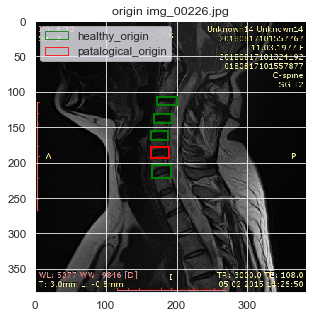

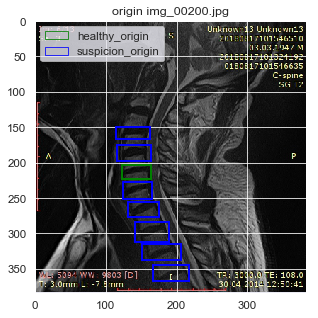

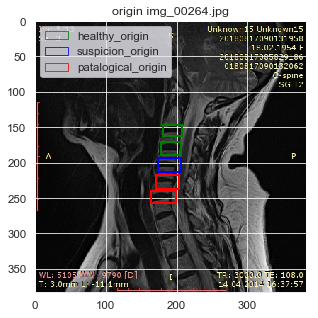

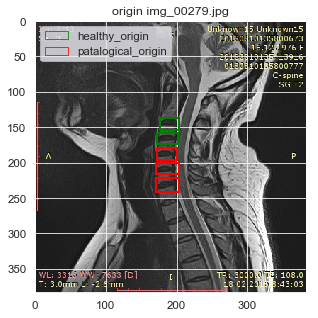

In [14]:
for img in mri_clean['file'].unique()[0:4]:
    plots = du.draw_img(df=[mri_clean], 
                        img_name=img,
                        types_df=['origin'],
                        dir_img=const.PATH_IMG, 
                        color_patch=const.COLORS, 
                        figsize=(5, 5),
                        numsubplots=1)

## 4. Prepare data for yolo <a class="anchor" id="prepare_yolo"></a>

### 4.1. Copy obj.names and obj.data to data/

In [15]:
yu.copy_files(dir_from=const.ROOT + '/cfg/',
              dir_to=const.PATH_DARKNET + 'data/',
              files=['obj.names', 'obj.data'])

[{upload_yolo_utils.py:27} INFO - Copy from /Users/valeriakaravaeva/Documents/git/_LK/MRI_yolo/cfg/ 
 to 
 /Users/valeriakaravaeva/Documents/git/_LK/MRI_yolo/darknet/build/darknet/x64/data/
[{upload_yolo_utils.py:33} INFO - Success copy 2 files


### 4.2. Copy cfg yolo.cfg to cfg/

In [16]:
yu.copy_files(dir_from=const.ROOT + '/cfg/',
              dir_to=const.PATH_DARKNET + 'cfg/',
              files=['yolo.cfg'])

[{upload_yolo_utils.py:27} INFO - Copy from /Users/valeriakaravaeva/Documents/git/_LK/MRI_yolo/cfg/ 
 to 
 /Users/valeriakaravaeva/Documents/git/_LK/MRI_yolo/darknet/build/darknet/x64/cfg/
[{upload_yolo_utils.py:33} INFO - Success copy 1 files


### 4.3. Copy all images to data/obj (and create obj/ dir)

In [17]:
if not os.path.exists(const.PATH_DARKNET + 'data/obj'):
    os.makedirs(const.PATH_DARKNET + 'data/obj')

In [18]:
yu.copy_files(dir_from=const.PATH_IMG,
              dir_to=const.PATH_DARKNET + 'data/obj',
              files=imgs_set['main'])

[{upload_yolo_utils.py:27} INFO - Copy from /Users/valeriakaravaeva/Documents/git/_LK/MRI_yolo/data/images/ 
 to 
 /Users/valeriakaravaeva/Documents/git/_LK/MRI_yolo/darknet/build/darknet/x64/data/obj
[{upload_yolo_utils.py:33} INFO - Success copy 339 files


### 4.4. Create for each images txt file with polygon (to data/obj)

In [19]:
yu.img_txt(df=mri_clean,
           dir_to=const.PATH_DARKNET + 'data/obj', 
           img_size=const.IMG_SIZE,
           columns_yolo=const.COLUMNS_YOLO,
           imgs=imgs_set['main'])

[{upload_yolo_utils.py:39} INFO - Create txt file to dir 
 /Users/valeriakaravaeva/Documents/git/_LK/MRI_yolo/darknet/build/darknet/x64/data/obj
[{upload_yolo_utils.py:47} INFO - Success create 339 files txt


### 4.5. Copy create test and train images and save to data/

In [20]:
test_set, train_set = yu.test_train_files(test_set=imgs_set['test'],
                                          train_set=imgs_set['train'],
                                          dir_to_file='data/obj/',
                                          dir_to=const.PATH_DARKNET + 'data/')

[{upload_yolo_utils.py:56} INFO - Write test file 101 to 
 /Users/valeriakaravaeva/Documents/git/_LK/MRI_yolo/darknet/build/darknet/x64/data/
[{upload_yolo_utils.py:62} INFO - Write train file 238 to 
 /Users/valeriakaravaeva/Documents/git/_LK/MRI_yolo/darknet/build/darknet/x64/data/


## 5. Evaluate <a class="anchor" id="eval"></a>

### 5.1. Class YoloModels

Darknet YOLO saves weight each 1000 epochs. And we have 40 files of weight. Let's see how error has changed.

We have class of **YoloModels** with two main methods:
* **get_predict_models():** save predictions for each models
* **get_metrics_models()** return all metrics for each models and each label (patalogical, suspicion, healthy):
    * f1 score
    * recall
    * precision
    * mAP
    

In [22]:
models =  [(2000*i) for i in range(1, 20+1)]

In [23]:
models_obj = YoloModels(path_origin=const.PATH_DATA + 'data_clean.csv',
                        path_pred=const.PATH_DATA + '{}_prediction.csv',
                        test_set=imgs_set['test'],
                        models=models,
                        cat_type=const.CAT_TYPE_DISK,
                        cfg=const.CFG_YOLO,
                        data=const.DATA_YOLO,
                        weights=const.WEIGHT_YOLO,
                        output_columns=const.COLUMNS_YOLO_OUT)

### 5.2. Get predicts

In [68]:
models_obj.get_predict_models()

[{yolo.py:101} INFO - Start load network
[{yolo.py:44} INFO - Encode to ascii
[{yolo.py:49} INFO - Load net b'/Users/valeriakaravaeva/Documents/git/_LK/MRI_yolo/darknet/build/darknet/x64/cfg/yolo.cfg' b'/Users/valeriakaravaeva/Documents/git/_LK/MRI_yolo/darknet/build/darknet/x64/backup/yolo_2000.weights'
[{yolo.py:52} INFO - Load meta b'/Users/valeriakaravaeva/Documents/git/_LK/MRI_yolo/darknet/build/darknet/x64/data/obj.data'
[{yolo.py:104} INFO - Start prediction
[{yolo.py:92} INFO - Write to /Users/valeriakaravaeva/Documents/git/_LK/MRI_yolo/data/2000_prediction.csv, cnt (480, 10)
[{yolo.py:101} INFO - Start load network
[{yolo.py:44} INFO - Encode to ascii
[{yolo.py:49} INFO - Load net b'/Users/valeriakaravaeva/Documents/git/_LK/MRI_yolo/darknet/build/darknet/x64/cfg/yolo.cfg' b'/Users/valeriakaravaeva/Documents/git/_LK/MRI_yolo/darknet/build/darknet/x64/backup/yolo_4000.weights'
[{yolo.py:52} INFO - Load meta b'/Users/valeriakaravaeva/Documents/git/_LK/MRI_yolo/darknet/build/darkn

[{yolo.py:101} INFO - Start load network
[{yolo.py:44} INFO - Encode to ascii
[{yolo.py:49} INFO - Load net b'/Users/valeriakaravaeva/Documents/git/_LK/MRI_yolo/darknet/build/darknet/x64/cfg/yolo.cfg' b'/Users/valeriakaravaeva/Documents/git/_LK/MRI_yolo/darknet/build/darknet/x64/backup/yolo_30000.weights'
[{yolo.py:52} INFO - Load meta b'/Users/valeriakaravaeva/Documents/git/_LK/MRI_yolo/darknet/build/darknet/x64/data/obj.data'
[{yolo.py:104} INFO - Start prediction
[{yolo.py:92} INFO - Write to /Users/valeriakaravaeva/Documents/git/_LK/MRI_yolo/data/30000_prediction.csv, cnt (434, 10)
[{yolo.py:101} INFO - Start load network
[{yolo.py:44} INFO - Encode to ascii
[{yolo.py:49} INFO - Load net b'/Users/valeriakaravaeva/Documents/git/_LK/MRI_yolo/darknet/build/darknet/x64/cfg/yolo.cfg' b'/Users/valeriakaravaeva/Documents/git/_LK/MRI_yolo/darknet/build/darknet/x64/backup/yolo_32000.weights'
[{yolo.py:52} INFO - Load meta b'/Users/valeriakaravaeva/Documents/git/_LK/MRI_yolo/darknet/build/da

### 5.3. Get metrics

In [24]:
metric_verbose, metric_summary = models_obj.get_metrics_models()

[{yolo_metrics_imgs.py:75} INFO - Metrics for model = 2000
[{yolo_metrics_imgs.py:96} INFO - Create summary
[{yolo_metrics_imgs.py:75} INFO - Metrics for model = 4000
[{yolo_metrics_imgs.py:96} INFO - Create summary
[{yolo_metrics_imgs.py:75} INFO - Metrics for model = 6000
[{yolo_metrics_imgs.py:96} INFO - Create summary
[{yolo_metrics_imgs.py:75} INFO - Metrics for model = 8000
[{yolo_metrics_imgs.py:96} INFO - Create summary
[{yolo_metrics_imgs.py:75} INFO - Metrics for model = 10000
[{yolo_metrics_imgs.py:96} INFO - Create summary
[{yolo_metrics_imgs.py:75} INFO - Metrics for model = 12000
[{yolo_metrics_imgs.py:96} INFO - Create summary
[{yolo_metrics_imgs.py:75} INFO - Metrics for model = 14000
[{yolo_metrics_imgs.py:96} INFO - Create summary
[{yolo_metrics_imgs.py:75} INFO - Metrics for model = 16000
[{yolo_metrics_imgs.py:96} INFO - Create summary
[{yolo_metrics_imgs.py:75} INFO - Metrics for model = 18000
[{yolo_metrics_imgs.py:96} INFO - Create summary
[{yolo_metrics_imgs.py:

### 5.4. Plot of metrics <a class="anchor" id="plots"></a>

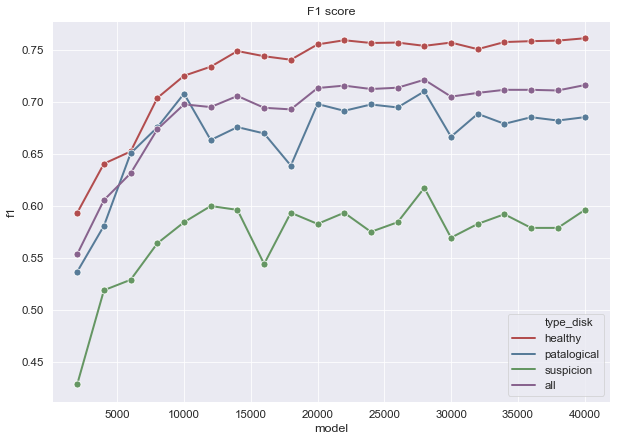

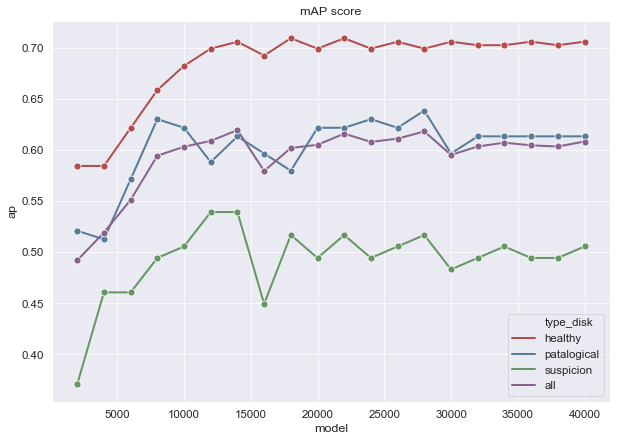

In [25]:
du.draw_metrics(x='model', 
                y='f1', 
                hue='type_disk',
                data=metric_summary, 
                figsize=(10,7),
                title='F1 score')


du.draw_metrics(x='model', 
                y='ap', 
                hue='type_disk',
                data=metric_summary, 
                figsize=(10,7),
                title='mAP score')

We can see that our model doesn't work well for **suspicion** class (perhaps this is a class specificity). 

### 5.5. Table of metrics

In [26]:
metric_summary[metric_summary.type_disk=='all']

type_disk   pb   ab   tp        ap precision    recall        f1  model
0       all  464  504  268  0.492085  0.577586  0.531746  0.553719   2000
0       all  404  504  275  0.519246  0.680693  0.545635  0.605727   4000
0       all  424  504  293  0.551241  0.691038  0.581349  0.631466   6000
0       all  428  504  314  0.594473  0.733645  0.623016  0.673820   8000
0       all  416  504  321  0.603300  0.771635  0.636905  0.697826  10000
0       all  431  504  325  0.608962   0.75406  0.644841  0.695187  12000
0       all  431  504  330  0.619617  0.765661  0.654762  0.705882  14000
0       all  406  504  316  0.579548  0.778325  0.626984  0.694505  16000
0       all  434  504  325  0.602048  0.748848  0.644841  0.692964  18000
0       all  407  504  325  0.605185  0.798526  0.644841  0.713502  20000
0       all  418  504  330  0.616054  0.789474  0.654762  0.715835  22000
0       all  411  504  326  0.607986  0.793187  0.646825  0.712568  24000
0       all  415  504  328  0.611183  0.790361  0.650794  0.713819  26000
0       all  408  504  329  0.618278  0.806373  0.652778  0.721491  28000
0       all  412  504  323  0.595289  0.783981  0.640873  0.705240  30000
0       all  413  504  325  0.603510  0.786925  0.644841  0.708833  32000
0       all  412  504  326  0.607255  0.791262  0.646825  0.711790  34000
0       all  412  504  326  0.604636  0.791262  0.646825  0.711790  36000
0       all  410  504  325  0.603510  0.792683  0.644841  0.711160  38000
0       all  409  504  327  0.608381  0.799511   0.64881  0.716320  40000

### 5.6. Visualization results <a class="anchor" id="visual"></a>

In [27]:
df_origin = models_obj.get_origin_df_by_model_id()
df_pred = models_obj.get_pred_df_by_model_id(model_id='40000')

#### Separate plots (It's just visualization)

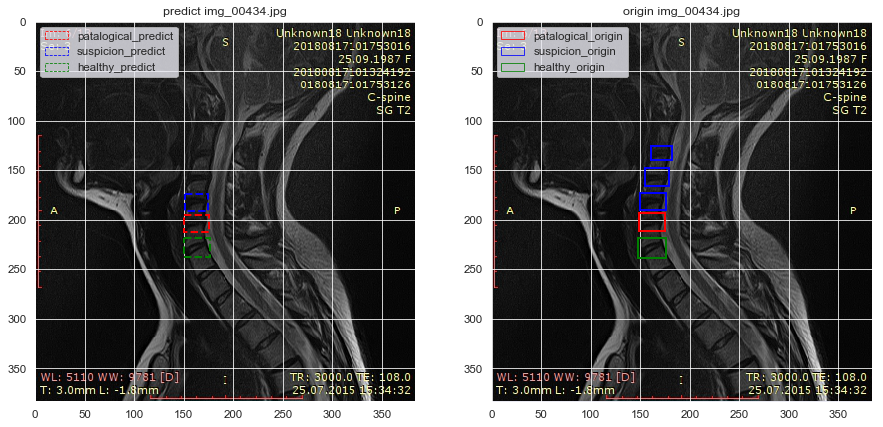

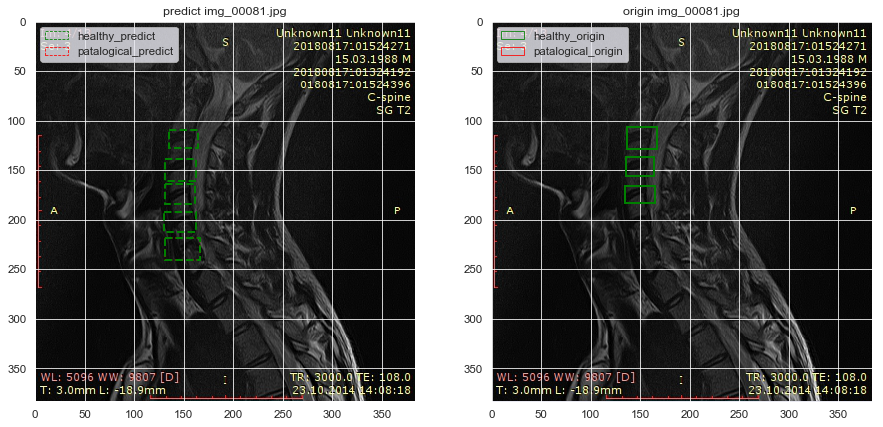

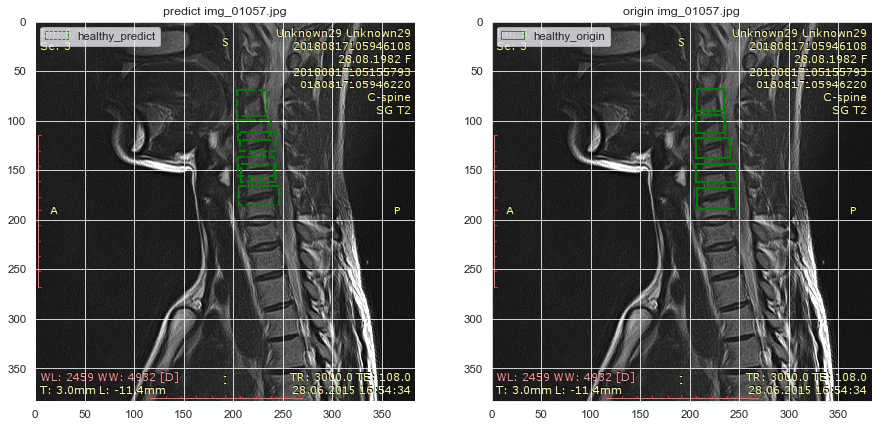

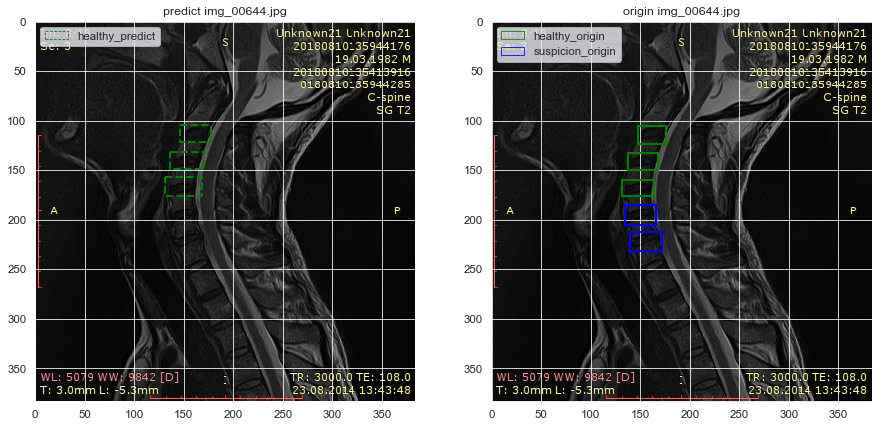

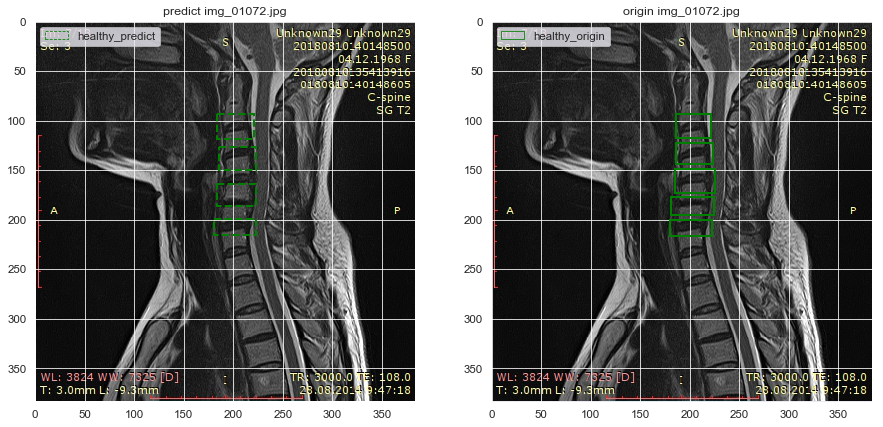

In [31]:
for i in test[0:5]:
    du.draw_img(df=[df_pred, df_origin], 
             types_df = ['predict', 'origin'],
             img_name=i, 
             dir_img=const.PATH_IMG, 
             figsize=(15, 15),
             color_patch=const.COLORS,
             numsubplots=2)

#### One plot

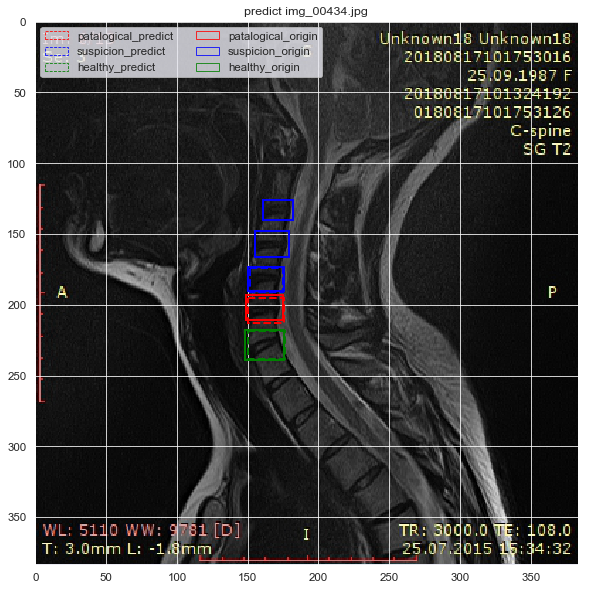

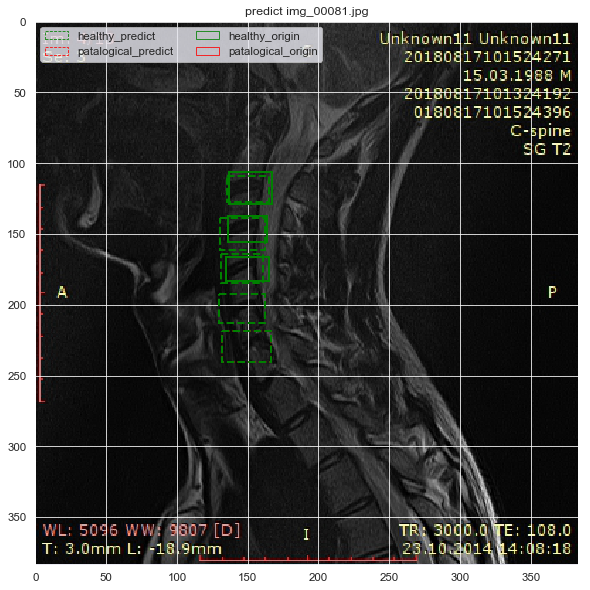

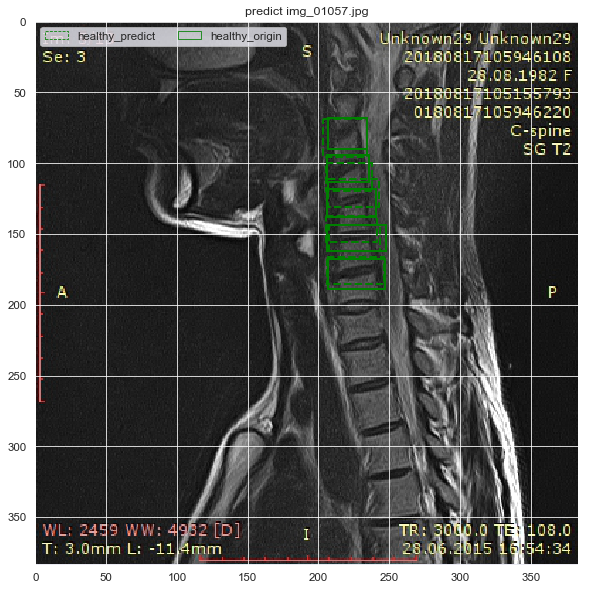

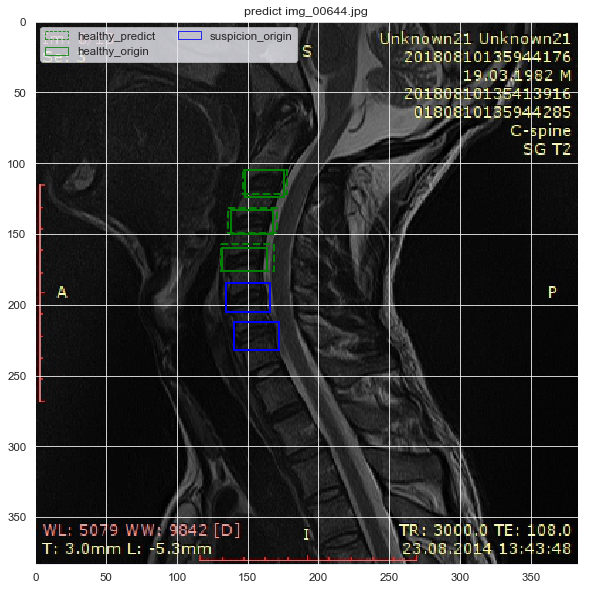

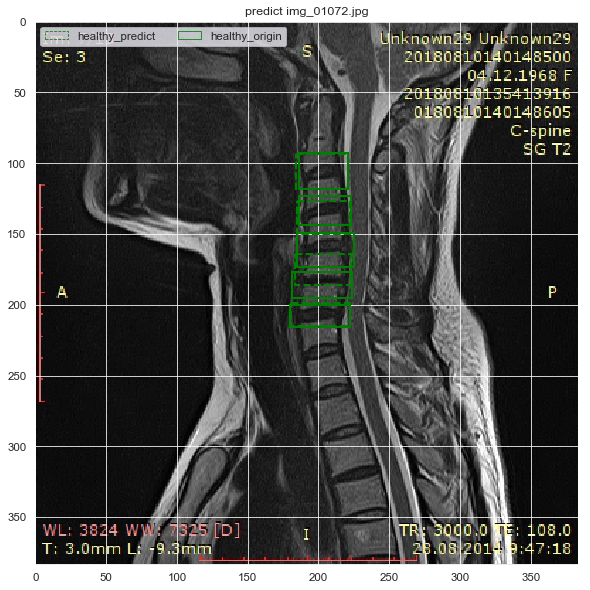

In [32]:
for i in test[0:5]:
    du.draw_img(df=[df_pred, df_origin], 
             types_df = ['predict', 'origin'],
             img_name=i, 
             dir_img=const.PATH_IMG, 
             figsize=(10, 10),
             color_patch=const.COLORS,
             numsubplots=1)

## 6. Conclusion

* Model works well for patalogical class and healthy
* We need improve our model for suspicion class
* We can improve model by adding more elements for train